# Importing Modules

In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Input, AveragePooling2D
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical 
from keras.applications.mobilenet_v2 import preprocess_input 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

from google.colab import files

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline

# Loading the Datasets

In [2]:
DIRECTORY = '/content/drive/MyDrive/Fire-Detector/Datasets'    # Path to the Datasets 
CATEGORIES = ['fire', 'non_fire']

data = []
labels = []

for category in CATEGORIES:
  path = os.path.join(DIRECTORY, category) 
  for img in os.listdir(path):
    img_path = os.path.join(path, img) 
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(category)

# Data Pre-processing

In [3]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [4]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [5]:
print(data.shape)
print(labels.shape)

(1656, 224, 224, 3)
(1656, 2)


## Data Splitting

In [6]:
(X_train_full, X_test, y_train_full, y_test) = train_test_split(data, labels, test_size = 0.20, stratify = labels)

In [7]:
print('X_train_full shape:', X_train_full.shape)
print('y_train_full shape:', y_train_full.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train_full shape: (1324, 224, 224, 3)
y_train_full shape: (1324, 2)
X_test shape: (332, 224, 224, 3)
y_test shape: (332, 2)


In [8]:
(X_train, X_valid, y_train, y_valid) = train_test_split(X_train_full, y_train_full, test_size = 0.10, stratify = y_train_full)

In [9]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)

X_train shape: (1191, 224, 224, 3)
y_train shape: (1191, 2)
X_valid shape: (133, 224, 224, 3)
y_valid shape: (133, 2)


## Data Augmentation

In [10]:
dataAug = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             shear_range=0.2,
                             fill_mode='nearest')

# Building a Model

In [11]:
INIT_LR = 1e-4  
EPOCHS = 20
BS = 32

In [15]:
def FireNet():

  baseModel = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
  Inputs = baseModel.input
  headModel = baseModel.output 
  headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
  headModel = Flatten(name='Flatten')(headModel)
  headModel = Dense(256, activation='relu')(headModel)
  headModel = Dropout(0.50)(headModel)
  headModel = Dense(128, activation='relu')(headModel)
  headModel = Dropout(0.50)(headModel)
  headModel = Dense(2, activation='softmax')(headModel)

  fire_net = Model(inputs = Inputs, outputs = headModel)
  
  for layer in baseModel.layers[:10]:
    layer.trainable = False
  
  adam = Adam(learning_rate = INIT_LR, decay = INIT_LR / EPOCHS)
  fire_net.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  fire_net.summary()

  return fire_net

In [16]:
fire_net = FireNet()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 2,619,074
Trainable params: 2,581,602
Non-trainable params: 37,472
__________________________________________________________________________________________________


# Training a Model

In [18]:
H = fire_net.fit(dataAug.flow(X_train, y_train, batch_size=BS), 
                      steps_per_epoch = len(X_train) // BS,
                      validation_data = (X_valid, y_valid),
                      epochs = EPOCHS)

Epoch 1/20
37/37 [==============================] - 57s 365ms/step - loss: 0.3556 - accuracy: 0.8385 - val_loss: 0.1315 - val_accuracy: 0.9624
Epoch 2/20
37/37 [==============================] - 12s 323ms/step - loss: 0.0919 - accuracy: 0.9659 - val_loss: 0.1228 - val_accuracy: 0.9624
Epoch 3/20
37/37 [==============================] - 12s 322ms/step - loss: 0.0926 - accuracy: 0.9751 - val_loss: 0.1515 - val_accuracy: 0.9474
Epoch 4/20
37/37 [==============================] - 12s 323ms/step - loss: 0.0425 - accuracy: 0.9894 - val_loss: 0.1596 - val_accuracy: 0.9699
Epoch 5/20
37/37 [==============================] - 12s 322ms/step - loss: 0.0371 - accuracy: 0.9838 - val_loss: 0.1228 - val_accuracy: 0.9774
Epoch 6/20
37/37 [==============================] - 12s 325ms/step - loss: 0.0567 - accuracy: 0.9803 - val_loss: 0.0842 - val_accuracy: 0.9850
Epoch 7/20
37/37 [==============================] - 12s 325ms/step - loss: 0.0989 - accuracy: 0.9659 - val_loss: 0.2698 - val_accuracy: 0.9173

# Saving a Model

In [ ]:
fire_net.save('/content/drive/MyDrive/Fire-Detector/Models/model-4', save_format='h5')

# Prediction using a Model

In [19]:
pred = fire_net.predict(X_test)
predictions = np.argmax(pred, axis=1)
actual_labels = np.argmax(y_test, axis=1)

In [20]:
print(pred.shape)
print(predictions.shape)
print(actual_labels.shape)
print(y_train.shape)

(332, 2)
(332,)
(332,)
(1191, 2)


In [21]:
classes = ['Fire', 'Non-Fire']

In [22]:
part_prediction = []
part_actual_labels = []
for i, j in zip(predictions[:10], actual_labels[:10]):
  part_prediction.append(classes[i])
  part_actual_labels.append(classes[j])

In [23]:
partial_data = {'Predictions' : part_prediction, 'Actual Labels' : part_actual_labels}
df = pd.DataFrame(partial_data)
df

,Predictions,Actual Labels
0,Fire,Fire
1,Non-Fire,Non-Fire
2,Fire,Fire
3,Fire,Fire
4,Non-Fire,Non-Fire
5,Non-Fire,Non-Fire
6,Fire,Fire
7,Non-Fire,Non-Fire
8,Fire,Fire
9,Fire,Fire


## On Test Datasets

In [24]:
n_img = 4
X_new = X_test[:n_img]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


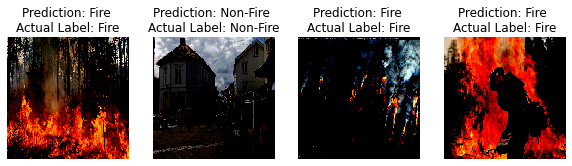

In [25]:
plt.figure(figsize=(2.5 * n_img, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, n_img, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(f'Prediction: {classes[predictions[index]]} \nActual Label: {classes[actual_labels[index]]}', fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## On Custom Images

On how many images would you like to test our model? 3


Saving fire.jpg to fire (1).jpg
Saving sun-2.jpg to sun-2 (1).jpg
Saving sun-3.jpg to sun-3.jpg


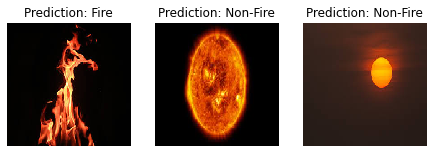

In [27]:
from keras.preprocessing import image
n_images = int(input('On how many images would you like to test our model? '))
plt.figure(figsize=(2.5 * n_images, 2.4))
uploaded = files.upload()
for img, index in zip(uploaded.keys(), range(n_images)):
  path = '/content/' + str(img)
  imagee = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(imagee)
  x = np.expand_dims(x, axis=0) / 255
  cust_pred = fire_net.predict(x)
  plt.subplot(1, n_images, index + 1)
  plt.imshow(imagee, cmap="binary", interpolation="nearest")
  plt.axis('off')
  idx = np.argmax(cust_pred[0])
  plt.title(f'Prediction: {classes[idx]}', fontsize=12)

# Model Evaluation

In [28]:
fire_net.evaluate(X_test, y_test)

11/11 [==============================] - 1s 44ms/step - loss: 0.1732 - accuracy: 0.9548


[0.1731717884540558, 0.9548192620277405]

In [29]:
precision = round(precision_score(actual_labels, predictions) * 100, 2)
accuracy = round(accuracy_score(actual_labels, predictions) * 100, 2)
recall = round(recall_score(actual_labels, predictions) * 100, 2)
f1 = round(f1_score(actual_labels, predictions) * 100, 2)
conf_mat = confusion_matrix(actual_labels, predictions)

In [30]:
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Confusion Matrix:\n {conf_mat}')

Accuracy: 95.48%
Precision: 92.31%
Recall: 98.73
F1-score: 95.41
Confusion Matrix:
 [[161  13]
 [  2 156]]


In [31]:
print(classification_report(actual_labels, predictions))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       174
           1       0.92      0.99      0.95       158

    accuracy                           0.95       332
   macro avg       0.96      0.96      0.95       332
weighted avg       0.96      0.95      0.95       332



## ROC Curve

In [32]:
fpr, tpr, thresholds = roc_curve(actual_labels, predictions)

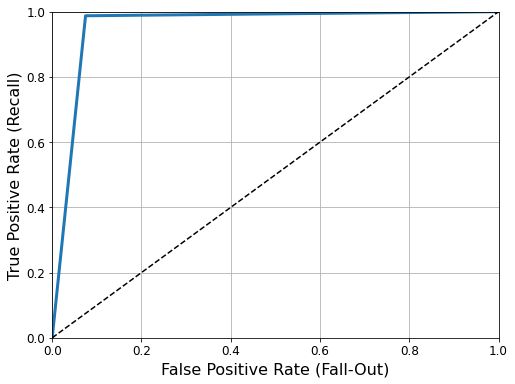

<Figure size 432x288 with 0 Axes>

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=3, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.show()
plt.savefig("/content/drive/MyDrive/Fire-Detector/Plots/roc/plot-2.png")

In [34]:
roc_auc_score(actual_labels, predictions)

0.956314564236869

## Loss/Accuracy vs Epochs Plot

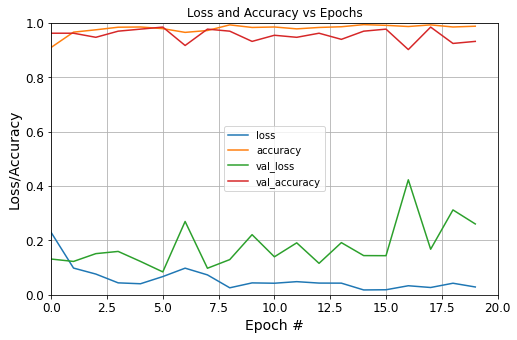

In [35]:
pd.DataFrame(H.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlim(0, EPOCHS)
plt.title("Loss and Accuracy vs Epochs")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center")
plt.show()